In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import PIL.ImageOps
from torch import nn
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm

In [2]:
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)) # mean=0.5, std deviation = 0.5
                                #Chage range [0, 1] in image to [-1, 1] => (0-0.5)/0.5 = -1, (1-0.5)/0.5 = 1
                                #(image - mean) / std
                               ])

training_dataset = datasets.CIFAR10(root = './data', train=True, download = True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root = './data', train=False, download = True, transform=transform)

training_batch_size = 32
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=training_batch_size, shuffle=True)

validation_batch_size = 100
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=validation_batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy().transpose(1, 2, 0) #(1, 28, 28) to (28, 28, 1)
    #Change range from [-1, 1] back to [0, 1]. image * std + mean
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    image = image.clip(0, 1)
    return image

In [4]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

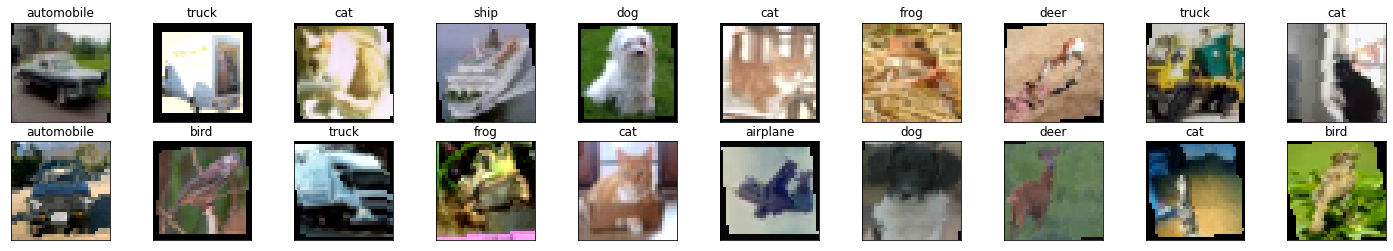

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [6]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) #Raw output, doesn't need activation function
        return x

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.5)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
                
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.pool(x)
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 64*4*4) # Flatten layer
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x),dim = 1)        
        return x

In [8]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
print("Device:", device)
#model = Classifier(784, 125, 65, 10).to(device)
#model = LeNet().to(device)
model = VGG("VGG16").to(device)
#summary(model, (1, 1, 28*28))
summary(model, (3, 32, 32))

Device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14      

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
epochs = 12
running_lost_history = []
running_corrects_history = []

val_running_lost_history = []
val_running_corrects_history = []
tbar = tqdm(range(epochs), desc = "Total Progress")
for epoch in tbar:
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    tqdm.write("Starting epoch {}/{}...".format(epoch+1, epochs))
    progress = tqdm(total=len(training_loader.dataset))
    for inputs, labels in training_loader:
        #inputs = inputs.view(inputs.shape[0], -1) #(100, 784)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1) # Output of torch.max = (max, max_indices)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        progress.update(inputs.shape[0])
    
    else:
        with torch.no_grad(): # Temporarily set all required grad flags to False
            for val_inputs, val_labels in validation_loader:
                #val_inputs = val_inputs.view(val_inputs.shape[0], -1) #(100, 784)
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1) # Output of torch.max = (max, max_indices)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                           
        epoch_loss = running_loss / len(training_loader) / training_batch_size
        epoch_acc = running_corrects.float() / len(training_loader) / training_batch_size * 100 #Accuracy rate
        running_lost_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)
        tqdm.write ("Training Loss: {:.4f}, acc: {:.2f}%".format(epoch_loss, epoch_acc.item()))
        
        val_epoch_loss = val_running_loss / len(validation_loader) / validation_batch_size
        val_epoch_acc = val_running_corrects.float() / len(validation_loader) / validation_batch_size * 100 #Accuracy rate
        val_running_lost_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        tqdm.write ("Validation Loss: {:.4f}, validation acc: {:.2f}%".format(val_epoch_loss, val_epoch_acc.item()))
    progress.close()

Starting epoch 1/12...


Training Loss: 0.0536, acc: 35.34%
Validation Loss: 0.0130, validation acc: 52.17%

Starting epoch 2/12...


Training Loss: 0.0395, acc: 54.07%
Validation Loss: 0.0098, validation acc: 64.58%

Starting epoch 3/12...


Training Loss: 0.0326, acc: 63.03%
Validation Loss: 0.0086, validation acc: 70.38%

Starting epoch 4/12...


Training Loss: 0.0285, acc: 68.18%
Validation Loss: 0.0077, validation acc: 74.02%

Starting epoch 5/12...


Training Loss: 0.0254, acc: 71.90%
Validation Loss: 0.0069, validation acc: 76.19%

Starting epoch 6/12...


Training Loss: 0.0229, acc: 74.80%
Validation Loss: 0.0062, validation acc: 79.42%

Starting epoch 7/12...


Training Loss: 0.0210, acc: 77.18%
Validation Loss: 0.0055, validation acc: 81.62%

Starting epoch 8/12...


Training Loss: 0.0194, acc: 79.09%
Validation Loss: 0.0052, validation acc: 82.52%

Starting epoch 9/12...


Training Loss: 0.0180, acc: 80.30%
Validation Loss: 0.0047, validation acc: 84.30%

Starting epoch 10/12...


Training Loss: 0.0170, acc: 81.58%
Validation Loss: 0.0047, validation acc: 83.92%

Starting epoch 11/12...


Training Loss: 0.0157, acc: 82.79%
Validation Loss: 0.0043, validation acc: 84.93%

Starting epoch 12/12...


Training Loss: 0.0148, acc: 83.61%
Validation Loss: 0.0042, validation acc: 85.87%




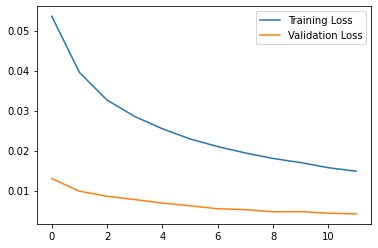

In [12]:
plt.plot(running_lost_history, label="Training Loss")
plt.plot(val_running_lost_history, label="Validation Loss")
plt.legend()

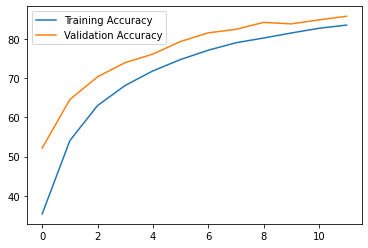

In [13]:
plt.plot(running_corrects_history, label = "Training Accuracy")
plt.plot(val_running_corrects_history, label = "Validation Accuracy")
plt.legend()

<Response [200]>


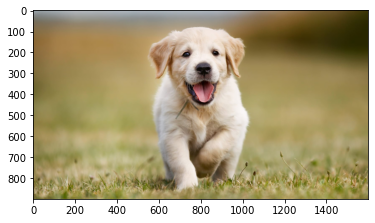

In [14]:
import requests
from PIL import Image
url = 'https://image.cnbcfm.com/api/v1/image/105992231-1561667465295gettyimages-521697453.jpeg?v=1561667497&w=1600&h=900'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
plt.imshow(img)

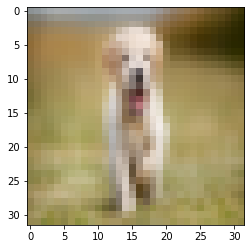

In [15]:
#img = PIL.ImageOps.invert(img)
#img = img.convert('1')
img = transform(img)
plt.imshow(im_convert(img))

In [16]:
val_input = img
#val_input = val_input.view(img.shape[0], -1) #(1, 784)
val_input = val_input.unsqueeze(0).to(device)
val_output = model(val_input)
_, val_pred = torch.max(val_output, 1)
print(classes[val_pred.item()])

airplane


Accuracy Rate = 86.0%


<Figure size 1800x288 with 0 Axes>

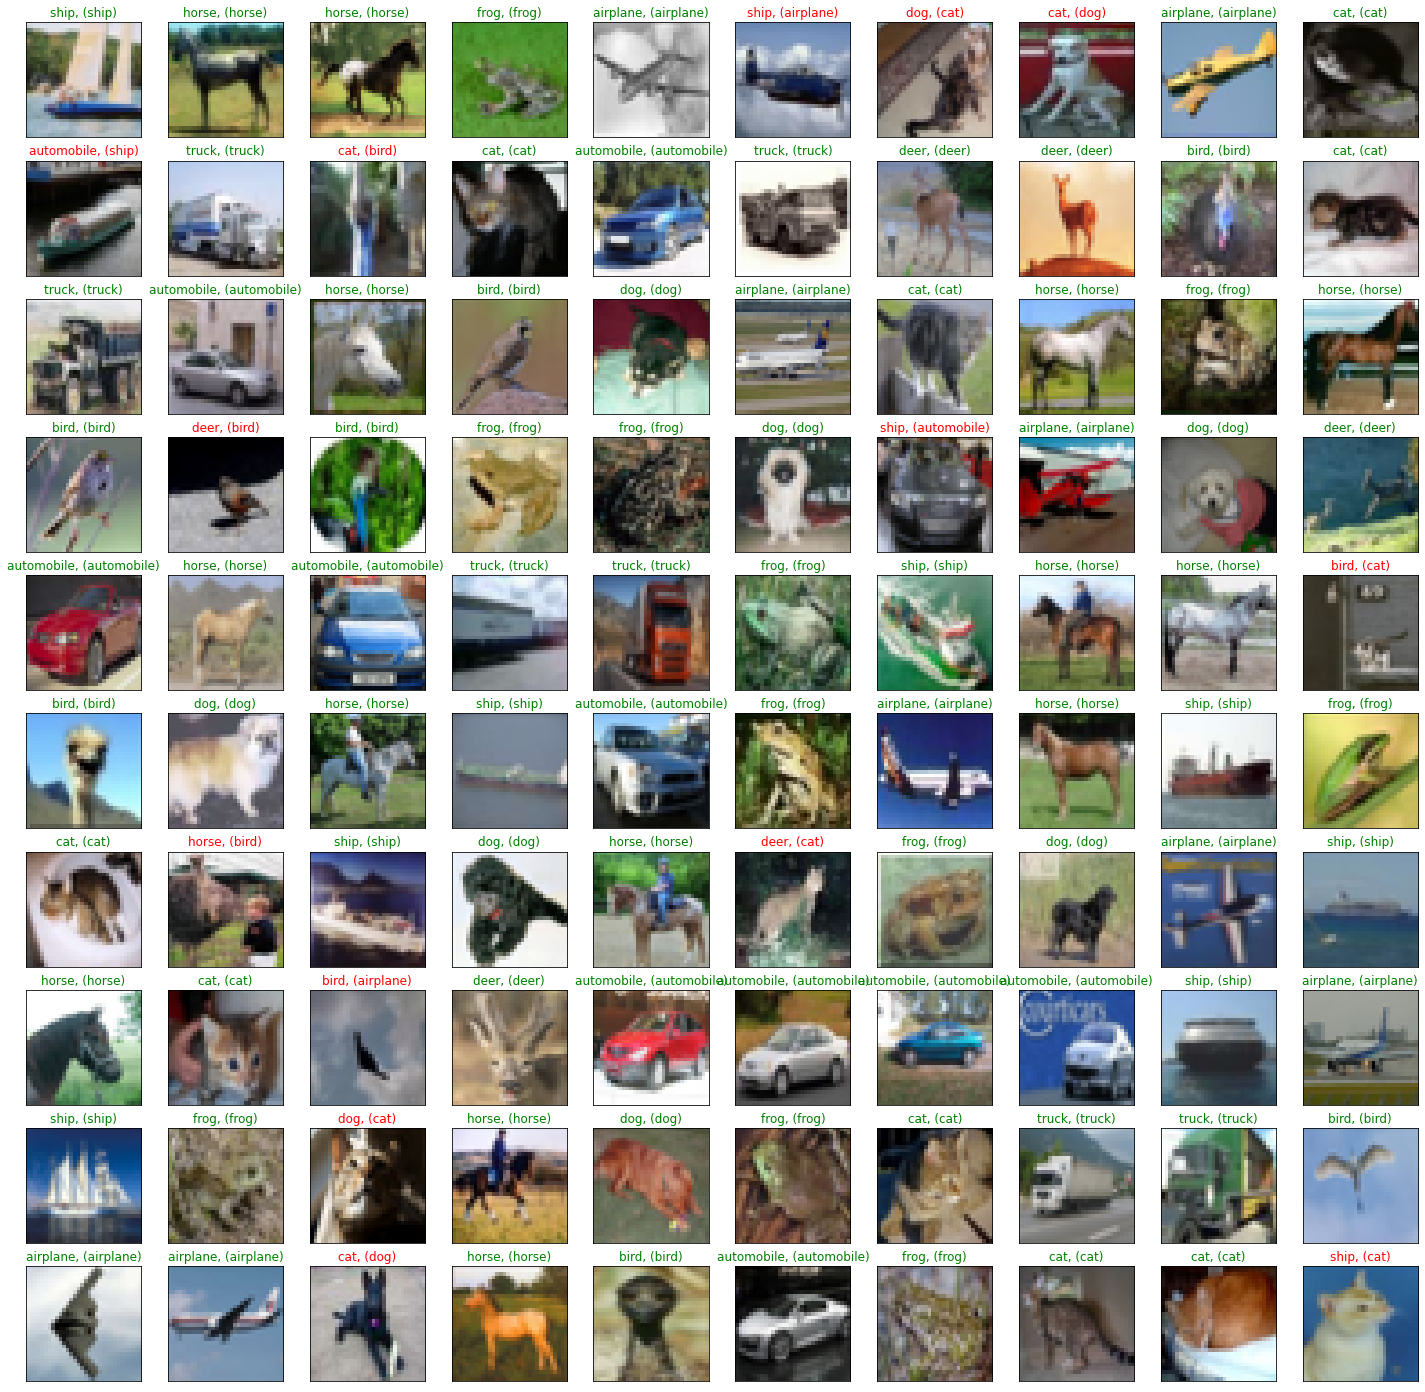

In [17]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(100):    
    ax = fig.add_subplot(10, 10, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))